<a href="https://colab.research.google.com/github/joshlijo/personal/blob/main/CrowdCountingComparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
import itertools

!pip install keras

from keras.utils import to_categorical
from keras.models import *
from keras.layers import *
from keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import vgg16, inception_v3, resnet50, VGG19
from tensorflow.keras import backend

sns.set(style='white', context='notebook', palette='deep')

In [2]:
pip install tensorflow

In [3]:
def add_one_to_one_correlation_line(ax, min_factor=1, max_factor=1, **plot_kwargs):
    lim_min, lim_max = pd.DataFrame([ax.get_ylim(), ax.get_xlim()]).agg({0: 'min', 1: 'max'})
    lim_min *= min_factor
    lim_max *= max_factor
    plot_kwargs_internal = dict(color='grey', ls='--')
    plot_kwargs_internal.update(plot_kwargs)
    ax.plot([lim_min, lim_max], [lim_min, lim_max], **plot_kwargs_internal)
    ax.set_ylim([lim_min, lim_max])
    ax.set_xlim([lim_min, lim_max])

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import zipfile
import os

zip_file_path = '/content/drive/MyDrive/crowd_counting.zip'  # Change this to the correct path if different
extract_path = '/content/crowd_counting'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List the extracted files to check
os.listdir(extract_path)

['labels.csv', 'images.npy', 'labels.npy', 'frames']

<Axes: >

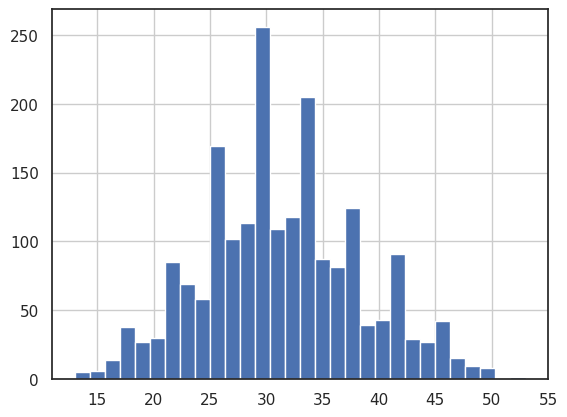

In [6]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/content/crowd_counting/labels.csv')  # Adjust the path as needed

# Map the image name based on the provided format
df['image_name'] = df['id'].map(lambda x: f'seq_{x:06d}.jpg')

# Describe and plot count distribution
df.describe()
df['count'].hist(bins=30)

In [7]:
# Parameters for the image size and batch size
size = 224
batch_size = 16

In [8]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Huber

datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,

    horizontal_flip=False,
    vertical_flip=False,
    validation_split=0.2,

    preprocessing_function=resnet50.preprocess_input,
)

In [9]:
flow_params = dict(
    dataframe=df,
    directory='/content/crowd_counting/frames/frames',
    x_col="image_name",
    y_col="count",
    weight_col=None,
    target_size=(size, size),
    color_mode='rgb',
    class_mode="raw",
    batch_size=batch_size,
    shuffle=True,
    seed=0,
)

In [10]:
train_generator = datagen.flow_from_dataframe(
    subset='training',
    **flow_params
)
valid_generator = datagen.flow_from_dataframe(
    subset='validation',
    **flow_params
)

Found 1600 validated image filenames.
Found 400 validated image filenames.


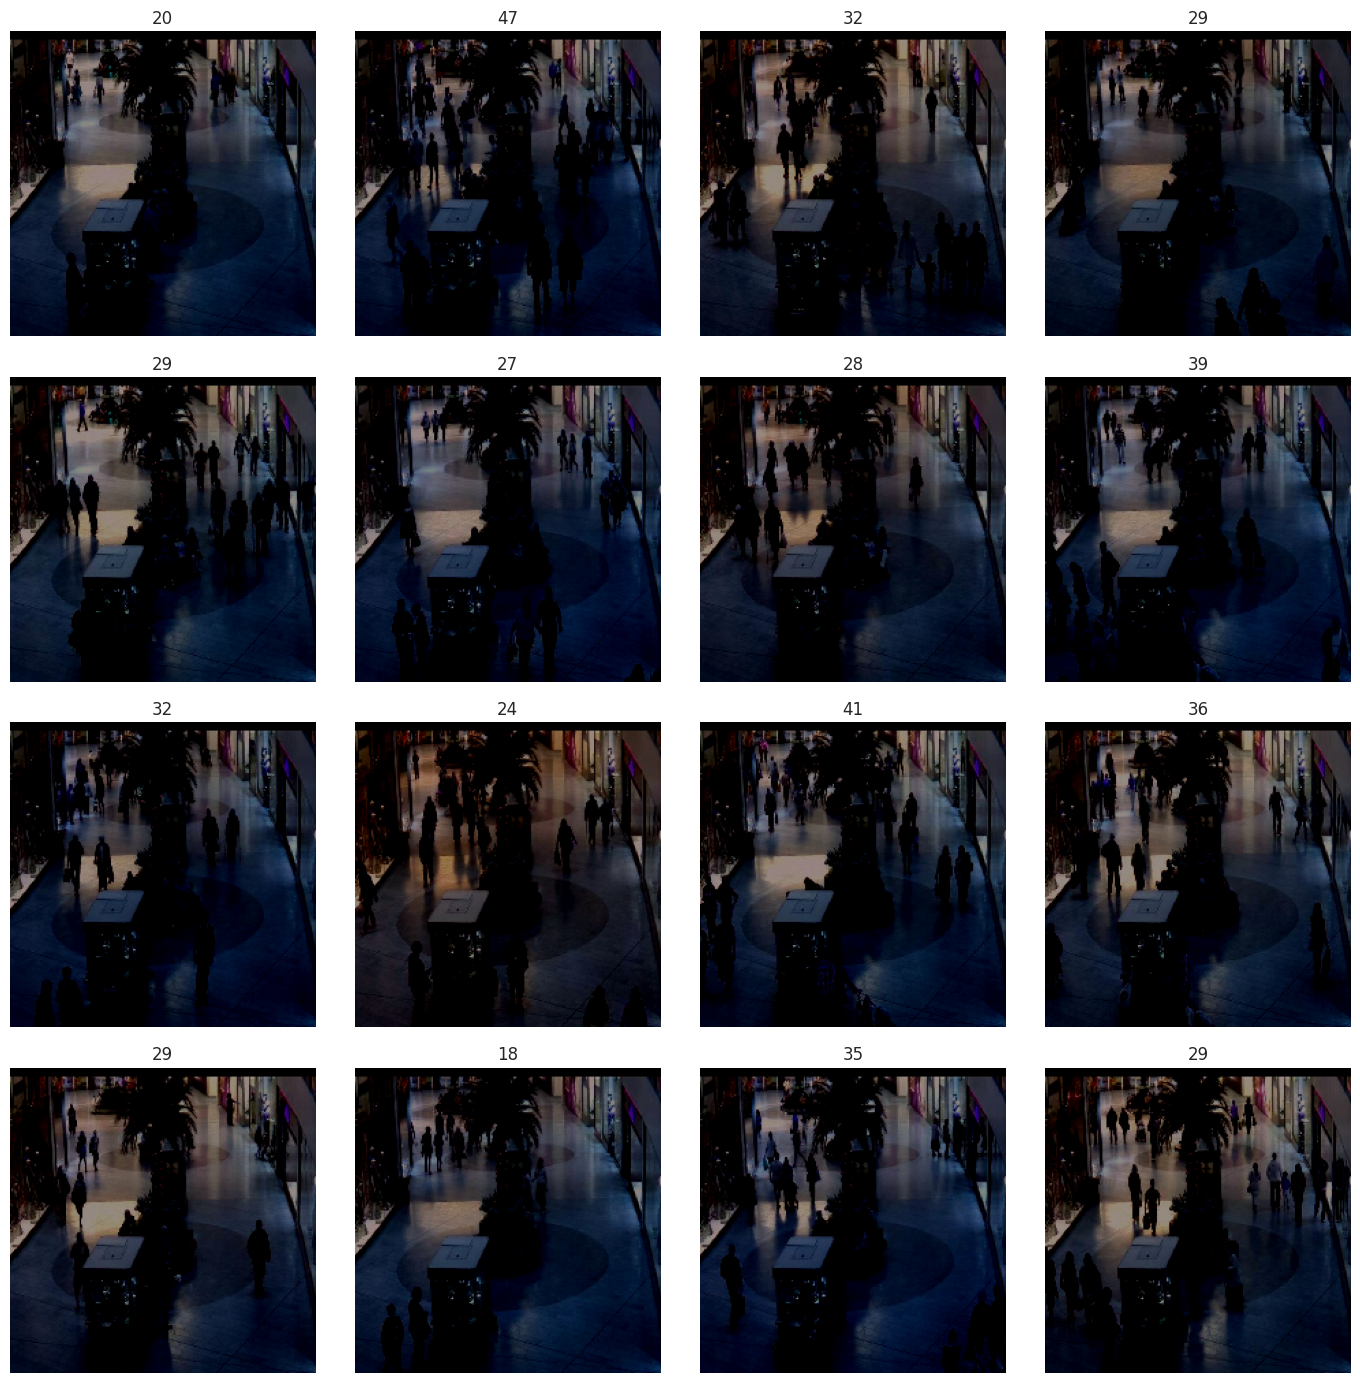

In [11]:
batch = next(train_generator)
fig, axes = plt.subplots(4, 4, figsize=(14, 14))
axes = axes.flatten()
for i in range(16):
    ax = axes[i]
    ax.imshow(batch[0][i])
    ax.axis('off')
    ax.set_title(batch[1][i])
plt.tight_layout()
plt.show()

# **RESNET50**

In [12]:
from tensorflow.keras.applications import ResNet50

base_model = resnet50.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(size, size, 3),
    pooling='avg',
)

In [13]:
x = base_model.output
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='linear')(x)

In [14]:
model = Model(inputs=base_model.input, outputs=predictions)

In [15]:
k = -7
for layer in model.layers[:k]:
    layer.trainable = False
print('Trainable:')
for layer in model.layers[k:]:
    print(layer.name)
    layer.trainable = True

Trainable:
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out
avg_pool
dense
dense_1


In [16]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 3,153,921 (12.03 MB)

 Non-trainable params: 22,532,992 (85.96 MB)

# Set up optimizer and annealer

In [17]:
df['count'] = df['count'].astype('float32')

In [18]:
optimizer = Adam(
    learning_rate=0.001,
)

In [19]:
model.compile(
    optimizer=optimizer,
    loss="mean_squared_error",
    metrics=['mean_absolute_error', 'mean_squared_error'],
    run_eagerly=True  # Enable eager execution
)

In [20]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_mean_squared_error',
    patience=3,
    verbose=1,
    factor=0.2,
    min_lr=0.000001
)

In [21]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=50,
    verbose=2,
    callbacks=[learning_rate_reduction]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-5fb773ca4ba0>", line 1, in <cell line: 1>
    history = model.fit(
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit
    logs = self.train_function(iterator)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator
    outputs = self.distribute_strategy.run(
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/distribute/distribute_lib.py", line 1673, i

TypeError: object of type 'NoneType' has no len()

In [ ]:
# Evaluation on Validation Set
val_loss, val_mae, val_mse = model.evaluate(valid_generator, verbose=1)
print(f"Validation MAE: {val_mae:.4f}")
print(f"Validation MSE: {val_mse:.4f}")

In [ ]:
# Predictions and Metrics Calculation
y_true = valid_generator.labels
y_pred = model.predict(valid_generator).flatten()
y_pred_rounded = np.rint(y_pred)

In [ ]:
# Calculate Metrics
accuracy = accuracy_score(y_true, y_pred_rounded)
precision = precision_score(y_true, y_pred_rounded, average='micro', zero_division=0)
recall = recall_score(y_true, y_pred_rounded, average='micro', zero_division=0)
f1 = f1_score(y_true, y_pred_rounded, average='micro', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_rounded)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# **VGG16**

In [12]:
base_model_VGG16 = vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(size, size, 3),
    pooling='avg',
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
# Here we change the top (the last parts) of the network.
x = base_model_VGG16.output  # Since we used pooling='avg', the output is of the pooling layer
x = Dense(1024, activation='relu')(x)  # We add a single fully-connected layer
predictions = Dense(1, activation='linear')(x)  # This is the new output layer - notice only 1 output, this will correspond to the number of people in the image

In [14]:
model2 = Model(inputs=base_model_VGG16.input, outputs=predictions)

In [15]:
k = -7
for layer in model2.layers[:k]:
    layer.trainable = False
print('Trainable:')
for layer in model2.layers[k:]:
    print(layer.name)
    layer.trainable = True

Trainable:
block5_conv1
block5_conv2
block5_conv3
block5_pool
global_average_pooling2d
dense
dense_1


In [16]:
model2.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         525,3

 Total params: 15,241,025 (58.14 MB)

 Trainable params: 7,605,761 (29.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

# Set up optimizer and annealer

In [17]:
# Define the optimizer - this function will iteratively improve parameters in order to minimise the loss.
# The Adam optimization algorithm is an extension to stochastic gradient descent, which is usually more effective and fast.
optimizer = Adam(
    # The most important parameter is the learning rate - controls the amount that the weights are updated during eache round of training.
    learning_rate=0.001,
    # Additional parameters to play with:
#     beta_1=0.9,
#     beta_2=0.999,
#     epsilon=1e-07,
)

In [18]:
# Compile the model
model2.compile(
    optimizer=optimizer,
    loss="mean_squared_error",  # This is a classic regression score - the lower the better
    metrics=['mean_absolute_error', 'mean_squared_error']
)

In [19]:
# Set a learning rate annealer - to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.
# The LR is decreased dynamically when the score is not improved. This keeps the advantage of the fast computation time with a high LR at the start.
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_mean_squared_error',  # Track the score on the validation set
    patience=3,  # Number of epochs in which no improvement is seen.
    verbose=1,
    factor=0.2,  # Factor by which the LR is multiplied.
    min_lr=0.000001  # Don't go below this value for LR.
)

In [20]:
history2 = model2.fit(
    x=train_generator,
    epochs=40,  # 40 epochs seems to have reached the minimal loss for this setup
    validation_data=valid_generator,
    verbose=2,
    callbacks=[learning_rate_reduction]
)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


KeyboardInterrupt: 

# **VGG19**

In [21]:
base_model_VGG19 = VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(size, size, 3),
    pooling='avg',
)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
# Here we change the top (the last parts) of the network.
x = base_model_VGG19.output  # Since we used pooling='avg', the output is of the pooling layer
x = Dense(1024, activation='relu')(x)  # We add a single fully-connected layer
predictions = Dense(1, activation='linear')(x)  # This is the new output layer - notice only 1 output, this will correspond to the number of people in the image

In [23]:
model3 = Model(inputs=base_model_VGG19.input, outputs=predictions)

In [24]:
k = -7
for layer in model3.layers[:k]:
    layer.trainable = False
print('Trainable:')
for layer in model3.layers[k:]:
    print(layer.name)
    layer.trainable = True

Trainable:
block5_conv2
block5_conv3
block5_conv4
block5_pool
global_average_pooling2d_1
dense_2
dense_3


In [25]:
model3.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,550,721 (78.39 MB)

 Trainable params: 7,605,761 (29.01 MB)

 Non-trainable params: 12,944,960 (49.38 MB)

# Set up Optimizer and Annealer

In [26]:
# Define the optimizer - this function will iteratively improve parameters in order to minimise the loss.
# The Adam optimization algorithm is an extension to stochastic gradient descent, which is usually more effective and fast.
optimizer = Adam(
    # The most important parameter is the learning rate - controls the amount that the weights are updated during eache round of training.
    learning_rate=0.001,
    # Additional parameters to play with:
#     beta_1=0.9,
#     beta_2=0.999,
#     epsilon=1e-07,
)

In [27]:
# Compile the model
model3.compile(
    optimizer=optimizer,
    loss="mean_squared_error",  # This is a classic regression score - the lower the better
    metrics=['mean_absolute_error', 'mean_squared_error']
)

In [28]:
# Set a learning rate annealer - to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.
# The LR is decreased dynamically when the score is not improved. This keeps the advantage of the fast computation time with a high LR at the start.
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_mean_squared_error',  # Track the score on the validation set
    patience=3,  # Number of epochs in which no improvement is seen.
    verbose=1,
    factor=0.2,  # Factor by which the LR is multiplied.
    min_lr=0.000001  # Don't go below this value for LR.
)

In [29]:
# Fit the model
history3 = model3.fit(
    x=train_generator,
    epochs=50,  # 50 epochs seems to have reached the minimal loss for this setup
    validation_data=valid_generator,
    verbose=2,
    callbacks=[learning_rate_reduction],
)
print('\nDone.')

Epoch 1/50


KeyboardInterrupt: 

# Evaluate the Model

In [ ]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(history1.history['loss'], color='b', label="Training loss")
ax.plot(history1.history['val_loss'], color='r', label="Validation loss")
ax.set_ylim(top=np.max(history1.history['val_loss'])*1.2, bottom=0)
legend = ax.legend(loc='best', shadow=True)
plt.show()

In [ ]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(history3.history['loss'], color='b', label="Training loss")
ax.plot(history3.history['val_loss'], color='r', label="Validation loss")
ax.set_ylim(top=np.max(history3.history['val_loss'])*1.2, bottom=0)
legend = ax.legend(loc='best', shadow=True)
plt.show()

In [ ]:
# Predict on entire validation set, to be able to review the predictions manually
valid_generator.reset()
all_labels = []
all_pred = []
for i in range(len(valid_generator)):
    x = next(valid_generator)
    pred_i = model1.predict(x[0])[:,0]
    labels_i = x[1]
    all_labels.append(labels_i)
    all_pred.append(pred_i)
#     print(np.shape(pred_i), np.shape(labels_i))

cat_labels_resnet = np.concatenate(all_labels)
cat_pred_resnet = np.concatenate(all_pred)

In [ ]:
# Predict on entire validation set, to be able to review the predictions manually
valid_generator.reset()
all_labels = []
all_pred = []
for i in range(len(valid_generator)):
    x = next(valid_generator)
    pred_i = model2.predict(x[0])[:,0]
    labels_i = x[1]
    all_labels.append(labels_i)
    all_pred.append(pred_i)
#     print(np.shape(pred_i), np.shape(labels_i))

cat_labels_vgg16 = np.concatenate(all_labels)
cat_pred_vgg16 = np.concatenate(all_pred)

In [ ]:
# Predict on entire validation set, to be able to review the predictions manually
valid_generator.reset()
all_labels = []
all_pred = []
for i in range(len(valid_generator)):
    x = next(valid_generator)
    pred_i = model3.predict(x[0])[:,0]
    labels_i = x[1]
    all_labels.append(labels_i)
    all_pred.append(pred_i)
#     print(np.shape(pred_i), np.shape(labels_i))

cat_labels_vgg19 = np.concatenate(all_labels)
cat_pred_vgg19 = np.concatenate(all_pred)

In [ ]:
df_predictions_resnet = pd.DataFrame({'True values': cat_labels_resnet, 'Predicted values': cat_pred_resnet})
ax = df_predictions_resnet.plot.scatter('True values', 'Predicted values', alpha=0.5, s=14, figsize=(9,9))
ax.grid(axis='both')
add_one_to_one_correlation_line(ax)
ax.set_title('Validation')

plt.show()

In [ ]:
df_predictions_vgg16 = pd.DataFrame({'True values': cat_labels_vgg16, 'Predicted values': cat_pred_vgg16})
ax = df_predictions_vgg16.plot.scatter('True values', 'Predicted values', alpha=0.5, s=14, figsize=(9,9))
ax.grid(axis='both')
add_one_to_one_correlation_line(ax)
ax.set_title('Validation')

plt.show()

In [ ]:
df_predictions_vgg19 = pd.DataFrame({'True values': cat_labels_vgg19, 'Predicted values': cat_pred_vgg19})
ax = df_predictions_vgg19.plot.scatter('True values', 'Predicted values', alpha=0.5, s=14, figsize=(9,9))
ax.grid(axis='both')
add_one_to_one_correlation_line(ax)
ax.set_title('Validation')

plt.show()

In [ ]:
mse_resnet = mean_squared_error(*df_predictions_resnet.T.values)
pearson_r_resnet = sc.stats.pearsonr(*df_predictions_resnet.T.values)[0]

print(f'MSE: {mse_resnet:.1f}\nPearson r: {pearson_r_resnet:.1f}')

In [ ]:
# Calculate variance of the true values
variance_actual = np.var(df_predictions_resnet['True values'])

# Compute the R² score (coefficient of determination)
r_squared_resnet = 1 - (mse_resnet / variance_actual)

# Display the R² score
print(f'R² (R-squared): {r_squared_resnet:.2f}')

In [ ]:
# Calculate MAPE for ResNet50
mape_resnet = np.mean(np.abs((df_predictions_resnet['True values'] - df_predictions_resnet['Predicted values']) / df_predictions_resnet['True values'])) * 100
print(f'ResNet50 MAPE: {mape_resnet:.2f}%')

# Calculate MAPE for VGG16
mape_vgg16 = np.mean(np.abs((df_predictions_vgg16['True values'] - df_predictions_vgg16['Predicted values']) / df_predictions_vgg16['True values'])) * 100
print(f'VGG16 MAPE: {mape_vgg16:.2f}%')

# Calculate MAPE for VGG19
mape_vgg19 = np.mean(np.abs((df_predictions_vgg19['True values'] - df_predictions_vgg19['Predicted values']) / df_predictions_vgg19['True values'])) * 100
print(f'VGG19 MAPE: {mape_vgg19:.2f}%')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scipy import stats

# Function to predict on the validation set and evaluate performance
def predict_and_evaluate(model, valid_generator, labels, title="Model"):
    valid_generator.reset()
    all_labels = []
    all_pred = []

    for i in range(len(valid_generator)):
        x = next(valid_generator)
        pred_i = model.predict(x[0])[:, 0]  # Get the predictions
        labels_i = x[1]  # Get the true labels
        all_labels.append(labels_i)
        all_pred.append(pred_i)

    # Concatenate all predictions and true labels
    cat_labels = np.concatenate(all_labels)
    cat_pred = np.concatenate(all_pred)

    # Create a DataFrame for better analysis
    df_predictions = pd.DataFrame({'True values': cat_labels, 'Predicted values': cat_pred})

    # Plot predictions vs true values
    ax = df_predictions.plot.scatter('True values', 'Predicted values', alpha=0.5, s=14, figsize=(9, 9))
    ax.grid(axis='both')
    add_one_to_one_correlation_line(ax)  # Function to add a 1-to-1 correlation line
    ax.set_title(f'{title} - Validation')
    plt.show()

    # Calculate MSE, MAPE, Pearson correlation, and R-squared score
    mse = mean_squared_error(cat_labels, cat_pred)
    mape = mean_absolute_percentage_error(cat_labels, cat_pred)
    pearson_r = stats.pearsonr(cat_labels, cat_pred)[0]

    variance_actual = np.var(cat_labels)
    r_squared = 1 - (mse / variance_actual)

    print(f"{title} - MSE: {mse:.1f}")
    print(f"{title} - MAPE: {mape:.1f}%")
    print(f"{title} - Pearson r: {pearson_r:.1f}")
    print(f"{title} - R²: {r_squared:.2f}")

# Now, evaluate all three models
predict_and_evaluate(model1, valid_generator, df['count'], title="ResNet50")
predict_and_evaluate(model2, valid_generator, df['count'], title="VGG16")
predict_and_evaluate(model3, valid_generator, df['count'], title="VGG19")

In [ ]:
import random
import cv2
import matplotlib.pyplot as plt

def display_predictions_on_images(model, valid_generator, model_name="Model", sample_count=5):
    """
    Display predictions on a few sample images from the validation set.
    """
    # Reset the validation generator to start from the beginning
    valid_generator.reset()

    # Randomly select a few indices for sample images
    random_indices = random.sample(range(len(valid_generator)), sample_count)

    # Set up the plot
    fig, axes = plt.subplots(1, sample_count, figsize=(20, 5))
    fig.suptitle(f"{model_name} Predictions on Sample Images", fontsize=16)

    for i, idx in enumerate(random_indices):
        # Load the image and true label
        x = next(valid_generator)
        img = x[0][0]  # The input image (first in batch)
        true_count = x[1][0]  # The true count label

        # Make a prediction using the model
        pred_count = int(round(model.predict(np.expand_dims(img, axis=0))[:, 0][0]))

        # Convert the image from RGB to BGR for OpenCV display
        img_display = cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_RGB2BGR)

        # Display the image with predictions and true count
        axes[i].imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
        axes[i].set_title(f"Actual: {true_count}\nPredicted: {pred_count}", fontsize=12)
        axes[i].axis('off')

    plt.show()

# Display predictions for each model
display_predictions_on_images(model1, valid_generator, model_name="ResNet50")
display_predictions_on_images(model2, valid_generator, model_name="VGG16")
display_predictions_on_images(model3, valid_generator, model_name="VGG19")